# Friends Script Generater

#### In this notebook, we will see how to create model for text generator. It could be boring but our dataset very interesting enough. 
#### Data all about famous TV series Friends. Our aim to generate script for  character of Friends. It must be very interesting to see how it would be.

#### Lets get started
<div style="width:100%;text-align: center;"> <img align=middle src="https://c.tenor.com/wrO1yNN4wUcAAAAC/friends-fountain.gif" alt="Heat beating" style="height:700px;margin-top:3rem;"> </div>

# LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import warnings
import nltk
import spacy
import re
from spacy import displacy
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

# READ DATA

> **Data includes only script of series**

In [2]:
path_of_file = '../input/friends-tv-show-script/Friends_Transcript.txt'
text = open(path_of_file, 'r').read()

# HOW IT LOOKS LIKE

In [3]:
text[:1000]

"THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\nWritten by: Marta Kauffman & David Crane\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\nMonica: There's nothing to tell! He's just some guy I work with!\nJoey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\nChandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\nPhoebe: Wait, does he eat chalk?\n(They all stare, bemused.)\nPhoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\nMonica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\nChandler: Sounds like a date to me.\n[Time Lapse]\nChandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\nAll: Oh, yeah. Had that dream.\nChandler: Then I look down, and I realize there's a phone... there.\nJoey: Instead of...?\nChandle

### Do you wonder which words the most used for scripts? so I  do :D

>This process will take a bit long due to the lenght of dataset 

>lets write function for calculation.

In [4]:
nlp = spacy.load('en_core_web_sm')
stopword = nltk.corpus.stopwords.words('english')
def text_cleaning(text):
    
    text = re.sub(r'[^\w\s]', '',str(text))             #Punctuations
    text=re.split("\W+",text)                           #Tokenizing
    text=[word for word in text if word not in stopword]#Stop words
    text = ' '.join(text)                              
    return text


def frequent_of_words(string):
    
    clean_string = text_cleaning(string)
    split_string = pd.DataFrame(clean_string.split(),columns=['Words'])
    split_string = split_string.value_counts()[:1000].reset_index(drop=False)[:1000]
    split_string.columns = ['Words','Count']
    return split_string

In [5]:
frequent_words = frequent_of_words(text)
frequent_words[:15].style.background_gradient(cmap='Blues')

,Words,Count
0,I,24491
1,Ross,12777
2,Rachel,12129
3,Monica,11906
4,Chandler,11855
5,Joey,11751
6,Phoebe,9821
7,Oh,7374
8,Im,6016
9,know,4896


In [6]:
fig = px.funnel(frequent_words[:15], x='Count', y='Words')
fig.show()

In [7]:
list_for_cloud = []
for i in frequent_words.Words:
    list_for_cloud.append(str(i))

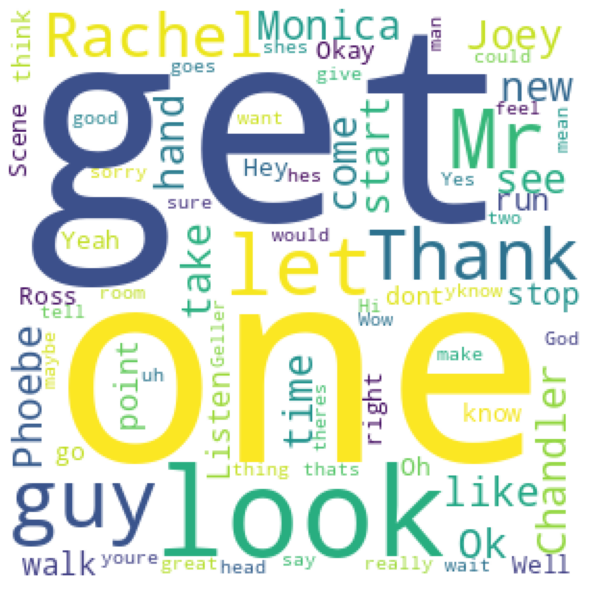

In [8]:

wordcloud = WordCloud(width = 300, height = 300,
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10).generate(' '.join(list_for_cloud))
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### I think some of the frequent words should be eleminated by stopwords but somehow stopwords failed to catch.

> #### Did yo trying to find "How you doin"?

<div style="width:100%;text-align: center;"> <img align=middle src="https://thumbs.gfycat.com/AdvancedAdventurousKoodoo-max-1mb.gif" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>

#### Which charachter has most script in th Show 

In [9]:
name_list = ['Joey','Monica','Phoebe','Chandler','Ross','Rachel']
scripts = []
split_string = text.split()
for name in name_list:
    scripts.append((name,split_string.count(name)))
    

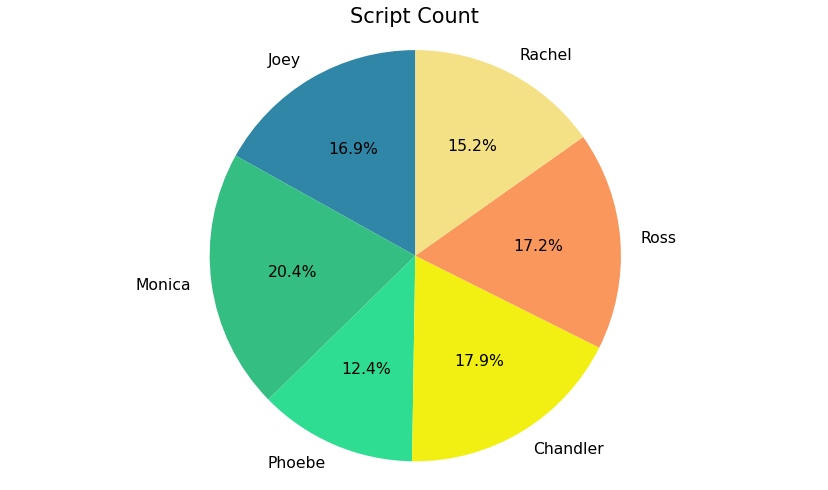

In [10]:
colors = ['#2F86A6','#34BE82','#2FDD92','#F2F013','#F9975D','#F4E185']
sections = [scripts[0][1],
            scripts[1][1],
            scripts[2][1],
            scripts[3][1],
           scripts[4][1],
           scripts[5][1]]
plt.figure(figsize=(14, 8), dpi=75)
plt.pie(sections, labels=name_list,colors=colors, 
        wedgeprops=dict( alpha=1),
        startangle=90,
        #explode = (0,0,0,0),
        autopct = '%0.1f%%',
         textprops={
                'fontsize': 15, 
                'fontweight': 'normal'}
            )

plt.axis('equal')
plt.title('Script Count',fontsize=20)
plt.show()

> **As we can see Monica has more script than others. However, almost every character have same scripts. 
Sadly, Phoebe lost this time :(**



<div style="width:50%;text-align: center;"> <img align=middle src="https://i.imgur.com/RQl7Toz.gif" alt="Heat beating" style="height:450px;margin-top:3rem;"> </div>


>**Monica(1st) and Chandler(2nd) won again :D**

# Prepare Data For Model

In [11]:
def target(text):
    input_txt = text[:-1]
    target = text[1:]
    return input_txt, target

vocab = sorted(set(text))
char_index = {u:i for i, u in enumerate(vocab)}
index_of_charachter = np.array(vocab)
encoded_text = np.array([char_index[c] for c in text])
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
sequence_lenght = 120
#+1 because of zero indexing
sequences = char_dataset.batch(sequence_lenght+1, drop_remainder=True)
dataset = sequences.map(target)
batch_size = 128
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

2021-12-17 12:47:24.326890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 12:47:24.328131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 12:47:24.328845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 12:47:24.330903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Now, we have ready data for train. Lets write class for all actions. **

# Creat Function for Prepare Dataset for RNN Model

In [12]:
class FriendsTextGenerator:
    '''
    TextGeneratorModel writed for generate text for famous serial Friends.
    Class Bulit with Tenserflow.
    This class has multifunction. It can train and save alse test ability.
    '''

    def loss_func(self,true,pred):
         return sparse_categorical_crossentropy(true, pred, from_logits=True) 
        
    def base_model(self,size_of_vocab=94,embedding_dim = 64,neurons = 1026,batch_size = 128):
      
        model = Sequential()
        model.add(Embedding(size_of_vocab, embedding_dim,batch_input_shape=[batch_size, None]))
        model.add(GRU(neurons,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
        model.add(Dense(size_of_vocab))
        model.compile(optimizer='adam', loss=self.loss_func) 
      
        return model
    
    def train_model(self,dataset,epoch=2,train_vb_size=94,em_dim = 64,rnn_nrs = 1026,batchs = 128):
        '''
        This funtion used for train model with defined params

        '''
    
        model = self.base_model(size_of_vocab = train_vb_size,
                                embedding_dim = em_dim,
                                neurons = rnn_nrs,
                                batch_size = batchs)
        print('\n    --Model Creat Succesfully--   ')
        model.fit(dataset,epochs=epoch)
        model.save('friends.h5') 
        print('\n    --Model Saved Succesfully--   ')
        return model
    
    def use_trained_model(self,path):
        '''
        Function takes only path of trained model and generated sentence afterwords

        '''
        saved_model = self.base_model(size_of_vocab=94,embedding_dim = 64,neurons = 1026,batch_size=1)
        saved_model.load_weights(path)
        saved_model.build(tf.TensorShape([1, None]))
        print('\n    --Model ReCreat Succesfully--   ')
        return saved_model
    
    def generate_dialog(self,model, start_sentence,characters=100):
        '''
        Purpose of this function is generate senctence
        model : trained sequential model
        start_sentence : according to which word will be generate
        characters : lenght of generated sentence
        '''
    
        num_generate = characters
        change_char = {'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6,'&': 7,"'": 8,'(': 9,')': 10, '*': 11,'+': 12,',': 13,'-': 14,'.': 15,'/': 16,'0': 17,'1': 18,'2': 19,'3': 20,'4': 21,'5': 22,'6': 23,'7': 24,
        '8': 25,'9': 26,':': 27,';': 28,'<': 29,'=': 30,'>': 31,'?': 32,'@': 33,'A': 34,'B': 35,'C': 36,'D': 37,'E': 38,'F': 39,'G': 40,'H': 41,'I': 42,'J': 43,'K': 44,'L': 45,'M': 46,'N': 47,'O': 48,'P': 49,
        'Q': 50,'R': 51,'S': 52,'T': 53,'U': 54,'V': 55,'W': 56,'X': 57,'Y': 58,'Z': 59,'[': 60,']': 61,'^': 62,'_': 63,'`': 64,'a': 65,'b': 66,'c': 67,'d': 68,'e': 69,'f': 70,'g': 71,'h': 72, 'i': 73,'j': 74,
        'k': 75,'l': 76,'m': 77,'n': 78,'o': 79,'p': 80,'q': 81,'r': 82,'s': 83,'t': 84,'u': 85,'v': 86,'w': 87,'x': 88,'y': 89,'z': 90,'{': 91,'|': 92, '}': 93}
        vocab = ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
                 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}']
        
        index_of_charachter = np.array(vocab)
        # Vecotrizing sentecnce
        input_sentence = [change_char[chrr] for chrr in start_sentence]
        input_sentence = tf.expand_dims(input_sentence, 0)
        generated_txt = []
        model.reset_states()
        print('\n    --Dialog Creating--   ')
        for i in range(num_generate):
            
            predictions = model(input_sentence)
            predictions = tf.squeeze(predictions, 0)
            predictions = predictions / 1.0
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
            input_sentence = tf.expand_dims([predicted_id], 0)
            generated_txt.append(index_of_charachter[predicted_id])
       
        return (start_sentence + ''.join(generated_txt))

#### Create Class Instance

In [13]:
generator = FriendsTextGenerator()

# Train And Save Model

In [14]:
first_model = generator.train_model(dataset,epoch=35)


    --Model Creat Succesfully--   
Epoch 1/35


2021-12-17 12:47:33.769715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-17 12:47:37.216740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


316/316 [==============================] - 35s 94ms/step - loss: 2.5422
Epoch 2/35
316/316 [==============================] - 31s 93ms/step - loss: 1.6498
Epoch 3/35
316/316 [==============================] - 32s 93ms/step - loss: 1.3794
Epoch 4/35
316/316 [==============================] - 32s 94ms/step - loss: 1.2654
Epoch 5/35
316/316 [==============================] - 32s 93ms/step - loss: 1.2041
Epoch 6/35
316/316 [==============================] - 32s 94ms/step - loss: 1.1627
Epoch 7/35
316/316 [==============================] - 32s 95ms/step - loss: 1.1322
Epoch 8/35
316/316 [==============================] - 32s 93ms/step - loss: 1.1075
Epoch 9/35
316/316 [==============================] - 32s 94ms/step - loss: 1.0869
Epoch 10/35
316/316 [==============================] - 32s 94ms/step - loss: 1.0685
Epoch 11/35
316/316 [==============================] - 32s 94ms/step - loss: 1.0514
Epoch 12/35
316/316 [==============================] - 32s 94ms/step - loss: 1.0357
Epoch 13/35


In [15]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 64)           6016      
_________________________________________________________________
gru (GRU)                    (128, None, 1026)         3361176   
_________________________________________________________________
dense (Dense)                (128, None, 94)           96538     
Total params: 3,463,730
Trainable params: 3,463,730
Non-trainable params: 0
_________________________________________________________________


# Test With Saved Model

In [16]:
path = './friends.h5'
test_model = generator.use_trained_model(path)


    --Model ReCreat Succesfully--   


In [17]:
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 64)             6016      
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1026)           3361176   
_________________________________________________________________
dense_1 (Dense)              (1, None, 94)             96538     
Total params: 3,463,730
Trainable params: 3,463,730
Non-trainable params: 0
_________________________________________________________________


# Generate Dialog 

* **Test_model : our trained model for prediction**
* **String : start sentence for prediction**
* **Last variable for lenght of  generated text**

In [18]:
string = 'Happy End'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
Happy Endler trans I ever lost it. I like you alone so I can be picked up in the sex.
Gunther: That's what it takes to ask seeing eve weapoft. Can I be sleeping stuck right now?
Joey: Sure!
Monica: But I was kidding.
Janice: Oh, body? 
Joey: What?!
Rachel: We are touching me too!
Ross: Ahh!
Rachel: Youre gonna have a coat hanging out?
Rachel: Yeah.
Rachel: Anyway, umm, and tequila, fourteen pretty smokey will be computein marks one! And if I got it? I can do that!
Ross: Yeah, it hurts me a little bit? I mean my when I want to lose, come on in.
Emily: No, fleeve.
Joey: So? 
Monica: All right, lad: Do you want to.
Rachel: Oh.
{Jill start making out so I know Joe What-what did I see to do? Are-are you Chandler?
Phoebe: Yes!
Ross: You were waiting for it...
Amy: (To Phoebe) What the hell is she going home?
Rachel: No! No, forget about it then for a trem!
Amy: Oh wow! Oh yeah! You were gone!
Chandler: Ooh, you gotta take her up!
Ross: Hi! Okay-okay, you're there,

In [19]:
string = 'Lets code'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
Lets codes rainies her arm.) Oh!
Rachel: Youre smaller than your stupid Joey.
Joey: Which one? His name is CUrs?
Rachel: Well... what'd you ever been with?
Rachel: UThthey should go onto the game on Joey's parents into a lepo-armplant, so it doesnt work? Just for a couple for to soubboured floor gang.)
[Scene: Monica and Rachel's, Joey is drinking food and does him predector on their date, Ross and Mike enters)
Woman: Hi!
Ross: Hey! What is the Bad news!
(Phoebe jumps in the igloth suit breast missed out our closed shovel is starking again) ... ask your pope so there was a part of my flight states. So time now that I'm... naked for anyshirt, and whenever you want. And then y'know, this big stuff gave her a keep great. [Frannies  to fix-househ how much have to use the truth? Or and doctor. Go ahead and enjoy!
Ross: You're mean Monter. (in a sleeve one of those face again.)
Chandler: (shaking his head as an open Phoebes stampers) T.
Monica: Ahh.  SUSIE: Weere 

In [20]:
string = 'Monica and Chandler'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
Monica and Chandler have a limon other hand and decided to stick up a part or an holiday wiebe: Yeah! But I hired a little key, Trudy Scene: Central Perk. Rachel and Emma are already there. Rachel comes back a, you will have any accept for me.
Ross: You know the same sce'l broHes a little longer, but I can still see you too.
Rachel: What?
Ross: Well, lets play raciolation part of your aright words and you should go find a notescomporer in Rachel's, Monica and Chandler are starting in from the bedroom, tild none: Monica and Rachel's, Joey and Ross enter with his laptop]... ok lets talk about it.
Ross: Youre my brother?
Phoebe: Yeah, you did look through this! 
<Emma crawl suitranemmas picture earlier.
Ross: Maybe you can look at it!! (
The cookies else in trouble of it, who would do st. Ive got a second always pushed cracking Joey: Congratulations!/Ross, Joey and Ross return from Ross and says: Man? Really stupid your shirt. They kiss Phoebe lowgh- Lizz! Im g

In [21]:
string = 'we were on a break'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
we were on a break.
(Monica comes out from the opens, or I was in my bedroom?
Rachel: Feelings abored.
Rachel: Well tell me about it! And what are you, what? Ross, I cant stay for glaming in here!
Rachel: (caganned for an hour]
 and 115: Terrifordings.
Ross: No it... oh... Y'know, it's doct! You can't move in women written by Jims end of his bed.  PHOEBE: But please, I'm seeing a you and Rachel living inteer them up) And Im Dr. Scene, I just want you to know she is! (Pulls out a chaping completely.)
(Ross and Rachel look at each other)
[Time lapse, Ross and Rachel are calling all ok to work! (Rachel moves everybody giving as if women out of and been putting them off.)
Rachel: (likes the page) That is if someone elses are there original.
Ross: Which one?
Monica: I don't change. I'm still worrying about it hoebe...
Amy: oh my... my God.
[Cut to cabs, everybody has hit pants!
Rachel: Good luck! (Chandler looks around.) Okay, I'm sorry. I'm sorry! Honey, don't g

# End
#### There are a lot of things two say about this tv show. But I think main thing is model. Its not bad also not good but it works anyway . So I wish it will be inspired to someone. I hope you enjoy it. 


<div style="width:100%;text-align: center;"> <img align=middle src="https://uncleji.b-cdn.net//wp-content/uploads/2016/03/0.gif" alt="Heat beating" style="height:700px;margin-top:3rem;"> </div>
